In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
from nltk.tokenize import word_tokenize
import nltk
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from tqdm import tqdm
import torch.nn as nn
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# ignoring all the future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/viveksajithasujan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/viveksajithasujan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [3]:
def preprocess_text(text):
    # Extract text within <BOS> and <EOS> tokens
    match = re.search(r'<BOS>(.*?)<EOS>', text)
    if match:
        extracted_text = match.group(1)
    else:
        extracted_text = text
    # Remove punctuation and special characters
    extracted_text = re.sub(r"[^\w\s]", "", extracted_text)
    # Lowercase the text
    extracted_text = extracted_text.lower()
    return extracted_text

In [4]:
# Load the training and validation TSV files
train_path = "/Users/viveksajithasujan/Library/CloudStorage/OneDrive-UniversityofSussex/Term 2/Advanced NLP/Final Assignment/propaganda_dataset_v2/propaganda_train.tsv"
val_path = "/Users/viveksajithasujan/Library/CloudStorage/OneDrive-UniversityofSussex/Term 2/Advanced NLP/Final Assignment/propaganda_dataset_v2/propaganda_val.tsv"

# Read the TSV files
train_data = pd.read_csv(train_path, sep='\t')
test_data = pd.read_csv(val_path, sep='\t')

# Preview the first few rows of the training dataset
train_data.head()

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [5]:
# Drop rows where 'label' field is 'not_propaganda'
train_data = train_data[train_data['label'] != 'not_propaganda']
test_data = test_data[test_data['label'] != 'not_propaganda']

def plot_outliers(X_train, X_val):
    X_train_len = X_train.astype(str).apply(len)
    X_val_len = X_val.astype(str).apply(len)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.boxplot(x=X_train_len, ax=axes[0])
    axes[0].set_title("Train data length of sentences")
    sns.boxplot(x=X_val_len, ax=axes[1])
    axes[1].set_title("Validation data length of sentences")
    plt.show()

train_data.shape, test_data.shape

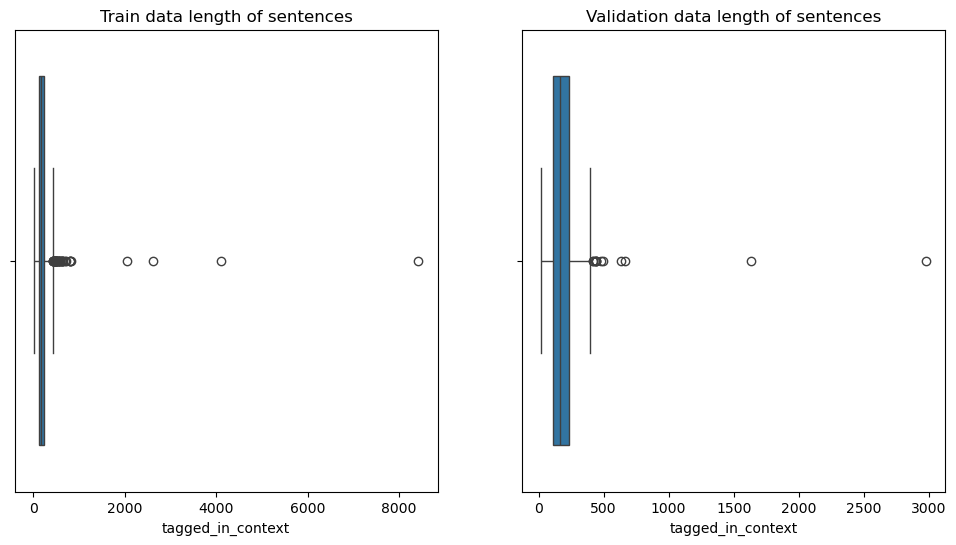

In [8]:
plot_outliers(train_data["tagged_in_context"], test_data["tagged_in_context"])

In [9]:
def remove_outliers(df, column, threshold=500):
    lengths = df[column].astype(str).apply(len)
    return df[lengths <= threshold]
train_data = remove_outliers(train_data, 'tagged_in_context', 500)
test_data = remove_outliers(test_data, 'tagged_in_context', 500)

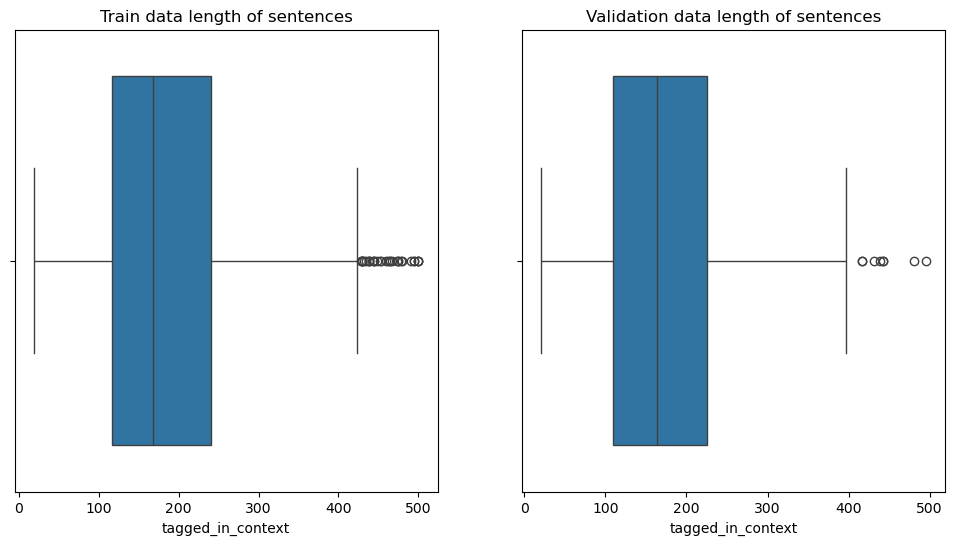

In [10]:
plot_outliers(train_data["tagged_in_context"], test_data["tagged_in_context"])

In [12]:
def plot_evaluation(y_val, y_pred):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val), ax=ax1)
    ax1.set_xlabel('Predicted Labels')
    ax1.set_ylabel('True Labels')
    ax1.set_title('Confusion Matrix')
    report = classification_report(y_val, y_pred, output_dict=True)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, ax=ax2)
    ax2.set_title('Classification Report')
    plt.tight_layout()
    plt.show()

In [13]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, name=""):
    print(f"Training and evaluating model: {model.__class__.__name__}")
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    print("\nAccuracy on validation data:", accuracy_score(y_val, predictions))
    print("\nClassification Report:")
    print(classification_report(y_val, predictions))
    plot_evaluation(y_val, predictions)

In [14]:
def tune_model(model, param_grid, X_train, y_train):
    print(f"Tuning model: {model.__class__.__name__}")
    grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best parameters:", grid_search.best_params_)
    return grid_search.best_estimator_

In [15]:
def compare_models(X_train_docs, y_train, X_val_docs, y_val, pipelines, param_grids, task=""):
    for name, pipeline in pipelines.items():
        print(f"\n{name} - Before Tuning:")
        train_and_evaluate(pipeline, X_train_docs, y_train, X_val_docs, y_val, name=f"{name}_Before_{task}")
        
        print(f"\n{name} - After Tuning:")
        
        best_model = tune_model(pipeline, param_grids[name], X_train_docs,y_train)
        
        train_and_evaluate(best_model, X_train_docs, y_train, X_val_docs, y_val, name=f"{name}_After_{task}")
        

In [16]:
train_data['processed_sentence'] = train_data['tagged_in_context'].apply(preprocess_text)
test_data['processed_sentence'] = test_data['tagged_in_context'].apply(preprocess_text)

In [17]:
train_data['tokenized_sentence'] = train_data['processed_sentence'].apply(word_tokenize)
test_data['tokenized_sentence'] = test_data['processed_sentence'].apply(word_tokenize)

In [18]:
tfidf_vectorizer = TfidfVectorizer(max_features=2000)  # Adjust max_features as needed
X_train = tfidf_vectorizer.fit_transform(train_data['processed_sentence'])
X_test = tfidf_vectorizer.transform(test_data['processed_sentence'])

In [19]:
# # Label encoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])

In [20]:
pipelines = { 'LogisticRegression':
Pipeline([
('clf', LogisticRegression(random_state=0, C = 0.001))
]),
'MultinomialNB': Pipeline([
('clf', MultinomialNB(alpha = 0.001))
])

            }

In [21]:
param_grids = {
'LogisticRegression': {
'clf__C': [0.001, 0.01, 0.1, 1, 10],
'clf__penalty': ['l1', 'l2'],
'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] #liblinear is good for small datasets and binary classification
},
'MultinomialNB': {
'clf__alpha': [0.001, 0.01, 0.1, 1, 10]
}}

In [48]:
X_test

<275x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 2127 stored elements in Compressed Sparse Row format>

In [50]:
# Get the mapping of labels to encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
for label, encoded in label_mapping.items():
    print(f"{encoded} → {label}")

0 → appeal_to_fear_prejudice
1 → causal_oversimplification
2 → doubt
3 → exaggeration,minimisation
4 → flag_waving
5 → loaded_language
6 → name_calling,labeling
7 → repetition



LogisticRegression - Before Tuning:
Training and evaluating model: Pipeline

Accuracy on validation data: 0.10181818181818182

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.00      0.00      0.00        31
           2       0.00      0.00      0.00        37
           3       0.10      1.00      0.18        28
           4       0.00      0.00      0.00        38
           5       0.00      0.00      0.00        37
           6       0.00      0.00      0.00        31
           7       0.00      0.00      0.00        31

    accuracy                           0.10       275
   macro avg       0.01      0.12      0.02       275
weighted avg       0.01      0.10      0.02       275



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa

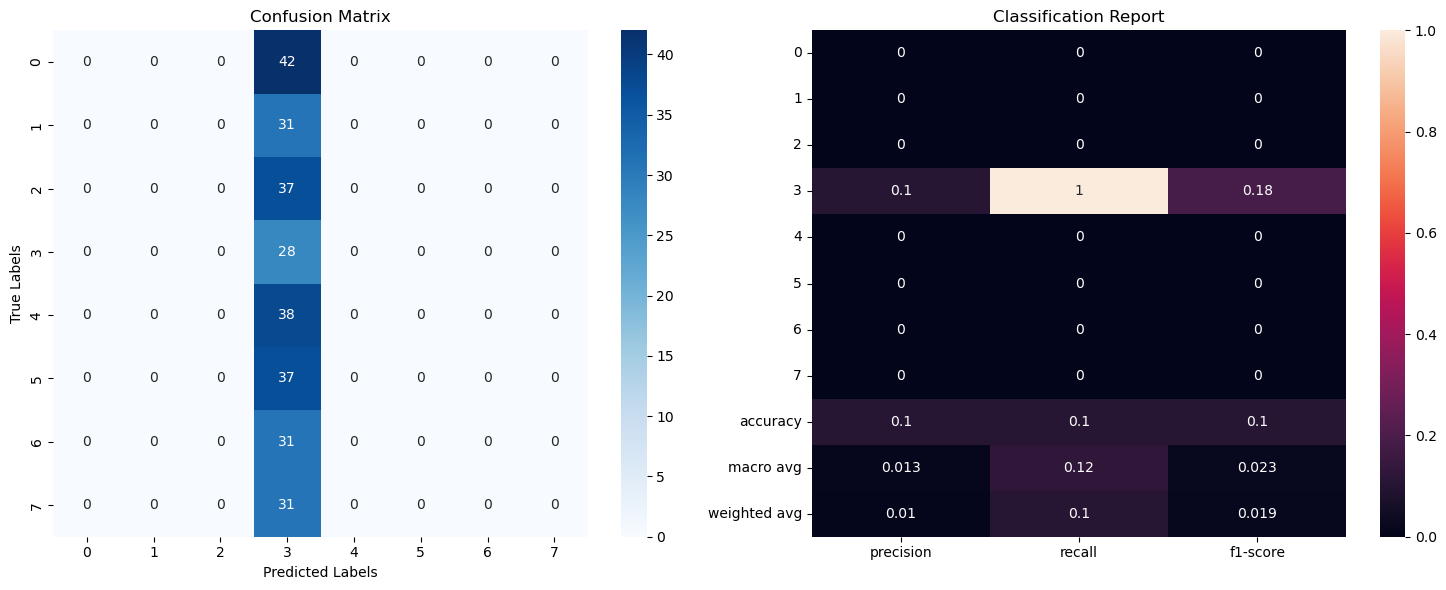


LogisticRegression - After Tuning:
Tuning model: Pipeline
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Training and evaluating model: Pipeline

Accuracy on validation data: 0.4690909090909091

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.52      0.51        42
           1       0.38      0.48      0.42        31
           2       0.37      0.43      0.40        37
           3       0.38      0.43      0.40        28
           4       0.77      0.61      0.68        38
           5       0.41      0.54      0.47        37
           6       0.53      0.32      0.40        31
           7       0.61      0.35      0.45        31

    accuracy                           0.47       275
   macro avg       0.49      0.46      0.47       275
weighted avg       0.50      0.47      0.47       275



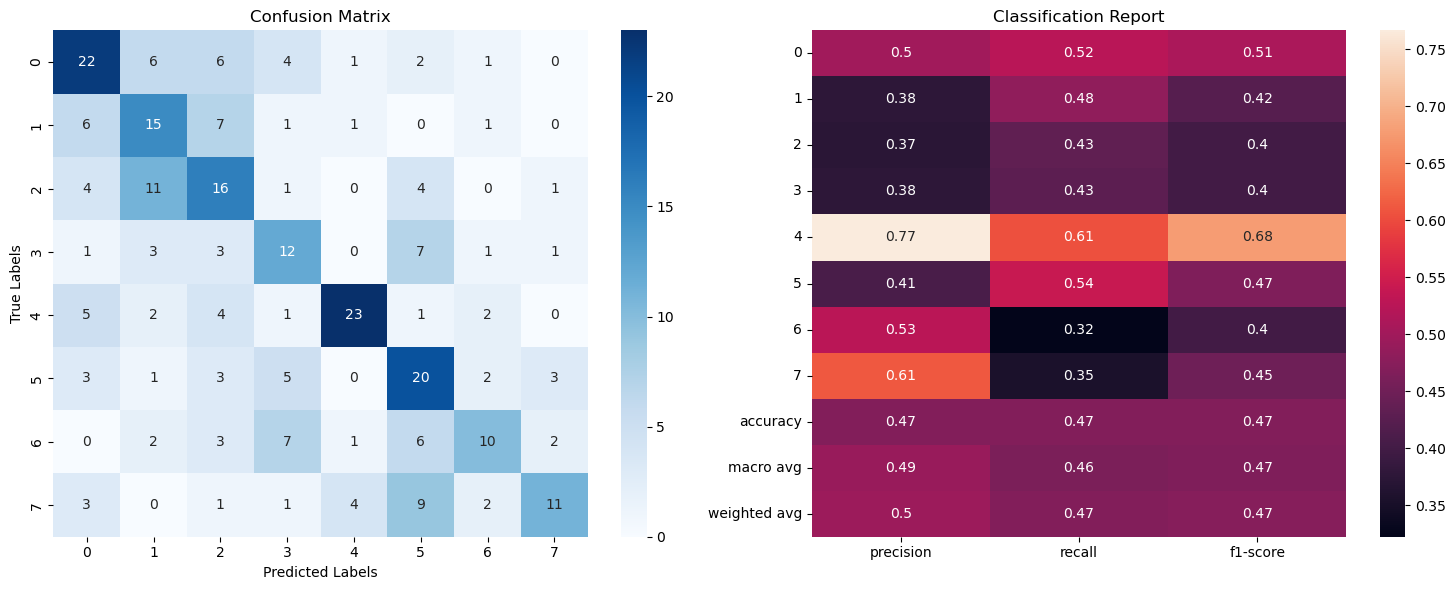


MultinomialNB - Before Tuning:
Training and evaluating model: Pipeline

Accuracy on validation data: 0.4

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.55      0.51        42
           1       0.31      0.48      0.38        31
           2       0.37      0.46      0.41        37
           3       0.22      0.46      0.30        28
           4       0.56      0.47      0.51        38
           5       0.50      0.16      0.24        37
           6       0.50      0.23      0.31        31
           7       0.69      0.35      0.47        31

    accuracy                           0.40       275
   macro avg       0.45      0.40      0.39       275
weighted avg       0.46      0.40      0.40       275



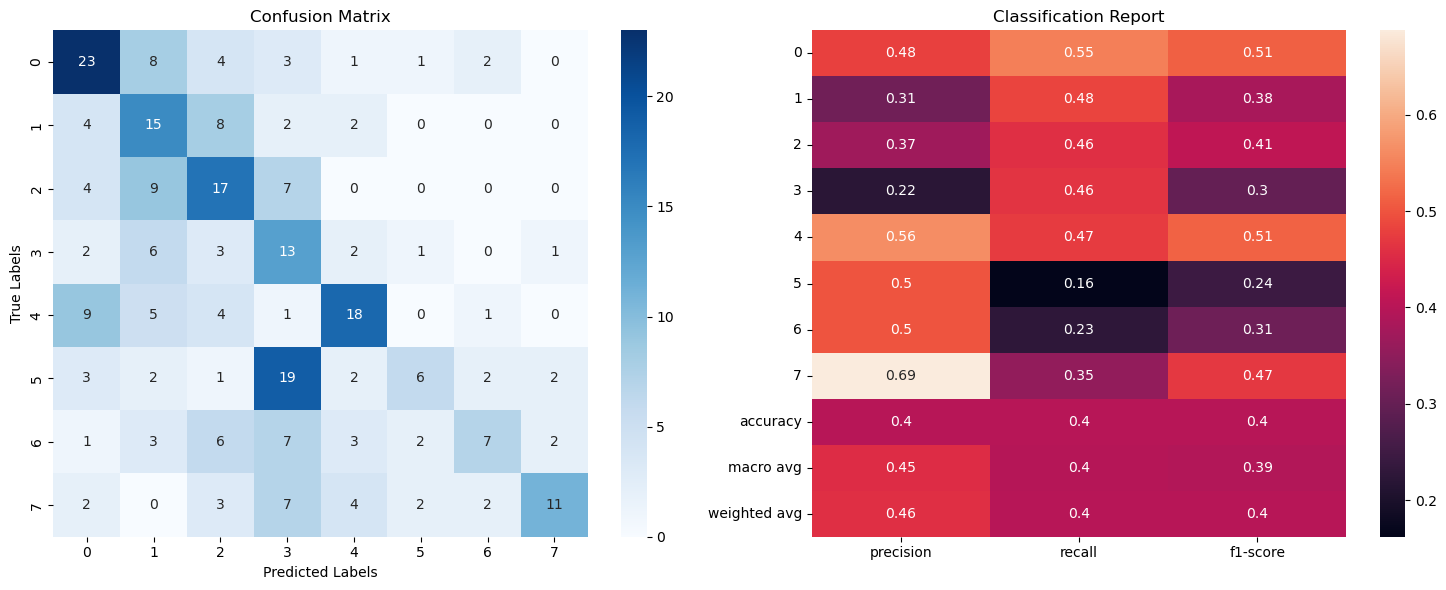


MultinomialNB - After Tuning:
Tuning model: Pipeline
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'clf__alpha': 0.1}
Training and evaluating model: Pipeline

Accuracy on validation data: 0.4036363636363636

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.55      0.54        42
           1       0.29      0.48      0.36        31
           2       0.34      0.43      0.38        37
           3       0.21      0.43      0.29        28
           4       0.67      0.58      0.62        38
           5       0.40      0.16      0.23        37
           6       0.53      0.26      0.35        31
           7       0.64      0.29      0.40        31

    accuracy                           0.40       275
   macro avg       0.45      0.40      0.40       275
weighted avg       0.46      0.40      0.40       275



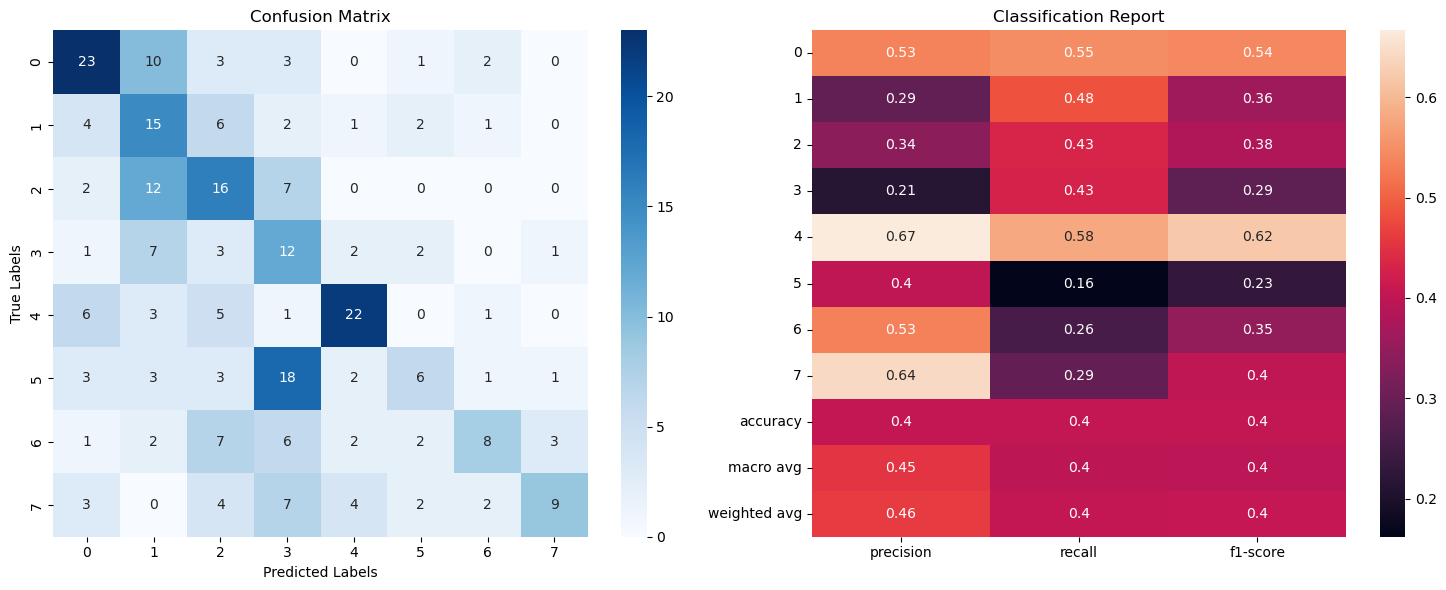

In [22]:
compare_models(X_train, y_train,
X_test, y_test,
pipelines, param_grids, task="21")

## Using Bert

In [24]:
train_data

,label,tagged_in_context,processed_sentence,tokenized_sentence
2,flag_waving,The Obama administration misled the <BOS> Amer...,american people,"[american, people]"
5,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans...",annihilated,[annihilated]
8,doubt,"As noted above, at this point literally every ...",socalled evidence,"[socalled, evidence]"
10,"name_calling,labeling",His account was suspended for violating Twitte...,hateful conduct,"[hateful, conduct]"
12,appeal_to_fear_prejudice,A couple of seemingly unrelated events this pa...,point to irans positioning itself for more ag...,"[point, to, irans, positioning, itself, for, m..."
...,...,...,...,...
2403,repetition,You might think that would have cured him of f...,nazi,[nazi]
2405,"exaggeration,minimisation",“I would like to take this opportunity to make...,absolutely no place for antisemitism,"[absolutely, no, place, for, antisemitism]"
2406,flag_waving,Trump To Jeff Sessions: Put An End to Russia P...,prosecutors doing muellers dirty work are a d...,"[prosecutors, doing, muellers, dirty, work, ar..."
2407,causal_oversimplification,<BOS> Neither the Democrat leadership nor the ...,neither the democrat leadership nor the democ...,"[neither, the, democrat, leadership, nor, the,..."


In [25]:
class BertClassifier(nn.Module):
    
    def __init__(self, dropout=dropouts, num_classes=2):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, input_ids, attention_mask=None, **kwargs):
        last_hidden_layer, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        return final_layer

In [56]:
train_data

,label,tagged_in_context,processed_sentence,tokenized_sentence
2,flag_waving,The Obama administration misled the <BOS> Amer...,american people,"[american, people]"
5,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans...",annihilated,[annihilated]
8,doubt,"As noted above, at this point literally every ...",socalled evidence,"[socalled, evidence]"
10,"name_calling,labeling",His account was suspended for violating Twitte...,hateful conduct,"[hateful, conduct]"
12,appeal_to_fear_prejudice,A couple of seemingly unrelated events this pa...,point to irans positioning itself for more ag...,"[point, to, irans, positioning, itself, for, m..."
...,...,...,...,...
2403,repetition,You might think that would have cured him of f...,nazi,[nazi]
2405,"exaggeration,minimisation",“I would like to take this opportunity to make...,absolutely no place for antisemitism,"[absolutely, no, place, for, antisemitism]"
2406,flag_waving,Trump To Jeff Sessions: Put An End to Russia P...,prosecutors doing muellers dirty work are a d...,"[prosecutors, doing, muellers, dirty, work, ar..."
2407,causal_oversimplification,<BOS> Neither the Democrat leadership nor the ...,neither the democrat leadership nor the democ...,"[neither, the, democrat, leadership, nor, the,..."


In [58]:


# Drop rows where 'label' field is 'not_propaganda'
train_data = train_data[train_data['label'] != 'not_propaganda']
test_data = test_data[test_data['label'] != 'not_propaganda']

# Tokenize and encode the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train = tokenizer(list(train_data['processed_sentence']), padding=True, truncation=True, return_tensors='pt', max_length=128)
X_test = tokenizer(list(test_data['processed_sentence']), padding=True, truncation=True, return_tensors='pt', max_length=128)



# Encode labels
label_encoder = LabelEncoder()
train_data['encoded_label'] = label_encoder.fit_transform(train_data['label'])
test_data['encoded_label'] = label_encoder.transform(test_data['label'])

# Convert labels to tensor
train_labels_tensor = torch.tensor(train_data['encoded_label'].values, dtype=torch.long)
test_labels_tensor = torch.tensor(test_data['encoded_label'].values, dtype=torch.long)

# Create DataLoader for training and testing data
train_dataset = TensorDataset(X_train['input_ids'], X_train['attention_mask'], train_labels_tensor)
test_dataset = TensorDataset(X_test['input_ids'], X_test['attention_mask'], test_labels_tensor)

In [64]:
def prepare_inputs(input_ids, attention_mask, labels, device):
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    return input_ids, attention_mask, labels

# Train and evaluate function
def train_and_evaluate(model, train_data, val_data, learning_rate, epochs, batch_size):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model.to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        model.train()
        train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
        for batch in tqdm(train_dataloader):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = prepare_inputs(input_ids, attention_mask, labels, device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss_train += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_acc_train += (predicted == labels).sum().item()

        total_acc_val = 0
        total_loss_val = 0
        model.eval()
        val_dataloader = DataLoader(val_data, batch_size=2)
        true_labels = []
        predictions = []
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                input_ids, attention_mask, labels = batch
                input_ids, attention_mask, labels = prepare_inputs(input_ids, attention_mask, labels, device)

                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

                total_loss_val += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_acc_val += (predicted == labels).sum().item()

                true_labels.extend(labels.tolist())
                predictions.extend(predicted.tolist())

        # Calculate evaluation metrics
        accuracy = accuracy_score(true_labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted', zero_division=1)
        report = classification_report(true_labels, predictions) 
        print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train / len(train_data):.3f}')
        print(f'Val loss: {total_loss_val / len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
        print("BERT Classifier Accuracy:", accuracy)
        print(report)
        # Append metrics for plotting
        train_losses.append(total_loss_train / len(train_data))
        train_accuracies.append(total_acc_train / len(train_data))
        val_losses.append(total_loss_val / len(val_data))
        val_accuracies.append(total_acc_val / len(val_data))

In [80]:
param_grid = {
    'dropout': [0.3, 0.5],
    'learning_rate': [2e-5, 3e-5],
    'batch_size': [4, 8],
    'num_epochs': [3, 4]
}


from itertools import product

# Get the keys and the values
keys = list(param_grid.keys())
values = list(param_grid.values())

# Generate all combinations
combinations = list(product(*values))

# Convert to list of lists
combinations_list = [list(comb) for comb in combinations]


# If you want just the raw list of lists:
print("\nList of Lists:\n", combinations_list)


List of Lists:
 [[0.3, 2e-05, 4, 3], [0.3, 2e-05, 4, 4], [0.3, 2e-05, 8, 3], [0.3, 2e-05, 8, 4], [0.3, 3e-05, 4, 3], [0.3, 3e-05, 4, 4], [0.3, 3e-05, 8, 3], [0.3, 3e-05, 8, 4], [0.5, 2e-05, 4, 3], [0.5, 2e-05, 4, 4], [0.5, 2e-05, 8, 3], [0.5, 2e-05, 8, 4], [0.5, 3e-05, 4, 3], [0.5, 3e-05, 4, 4], [0.5, 3e-05, 8, 3], [0.5, 3e-05, 8, 4]]


In [82]:
combinations_list

[[0.3, 2e-05, 4, 3],
 [0.3, 2e-05, 4, 4],
 [0.3, 2e-05, 8, 3],
 [0.3, 2e-05, 8, 4],
 [0.3, 3e-05, 4, 3],
 [0.3, 3e-05, 4, 4],
 [0.3, 3e-05, 8, 3],
 [0.3, 3e-05, 8, 4],
 [0.5, 2e-05, 4, 3],
 [0.5, 2e-05, 4, 4],
 [0.5, 2e-05, 8, 3],
 [0.5, 2e-05, 8, 4],
 [0.5, 3e-05, 4, 3],
 [0.5, 3e-05, 4, 4],
 [0.5, 3e-05, 8, 3],
 [0.5, 3e-05, 8, 4]]

In [84]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Initialize BERT Classifier
classifier = BertClassifier(num_classes=len(label_encoder.classes_))


num_epochs = 4
learning_rates = 2e-5
dropout = 0.5
batchsize = 4

# Train the model
# combinations_list = combinations_list[:1]
for i in combinations_list:
    dropout = i[0]
    learning_rates = i[1]
    batchsize = i[2]
    num_epochs = i[3]
    print('Running for combination: ', i)
    train_and_evaluate(classifier, train_dataset, test_dataset, learning_rate=learning_rates, epochs=num_epochs, batch_size = batchsize)

Running for combination:  [0.3, 2e-05, 4, 3]


100%|█████████████████████████████████████████| 138/138 [00:10<00:00, 12.91it/s]


Epochs: 1 | Train Loss: 0.480 | Train Accuracy: 0.263
Val loss: 0.797 | Val Accuracy: 0.473
BERT Classifier Accuracy: 0.4727272727272727
              precision    recall  f1-score   support

           0       0.45      0.31      0.37        42
           1       0.33      0.71      0.45        31
           2       0.82      0.24      0.38        37
           3       0.35      0.25      0.29        28
           4       0.58      0.84      0.69        38
           5       0.44      0.84      0.58        37
           6       0.69      0.35      0.47        31
           7       0.71      0.16      0.26        31

    accuracy                           0.47       275
   macro avg       0.55      0.46      0.44       275
weighted avg       0.55      0.47      0.44       275



100%|█████████████████████████████████████████| 138/138 [00:10<00:00, 12.88it/s]


Epochs: 2 | Train Loss: 0.355 | Train Accuracy: 0.501
Val loss: 0.640 | Val Accuracy: 0.549
BERT Classifier Accuracy: 0.5490909090909091
              precision    recall  f1-score   support

           0       0.57      0.55      0.56        42
           1       0.40      0.68      0.50        31
           2       0.70      0.43      0.53        37
           3       0.36      0.46      0.41        28
           4       0.80      0.63      0.71        38
           5       0.51      0.84      0.63        37
           6       0.76      0.61      0.68        31
           7       0.57      0.13      0.21        31

    accuracy                           0.55       275
   macro avg       0.58      0.54      0.53       275
weighted avg       0.59      0.55      0.54       275



100%|█████████████████████████████████████████| 138/138 [00:11<00:00, 12.17it/s]


Epochs: 3 | Train Loss: 0.230 | Train Accuracy: 0.708
Val loss: 0.566 | Val Accuracy: 0.604
BERT Classifier Accuracy: 0.6036363636363636
              precision    recall  f1-score   support

           0       0.68      0.62      0.65        42
           1       0.49      0.65      0.56        31
           2       0.67      0.54      0.60        37
           3       0.42      0.71      0.53        28
           4       0.79      0.82      0.81        38
           5       0.78      0.38      0.51        37
           6       0.75      0.68      0.71        31
           7       0.42      0.45      0.44        31

    accuracy                           0.60       275
   macro avg       0.63      0.61      0.60       275
weighted avg       0.64      0.60      0.61       275

Running for combination:  [0.3, 2e-05, 4, 4]


100%|█████████████████████████████████████████| 138/138 [00:11<00:00, 12.24it/s]


Epochs: 1 | Train Loss: 0.129 | Train Accuracy: 0.855
Val loss: 0.635 | Val Accuracy: 0.618
BERT Classifier Accuracy: 0.6181818181818182
              precision    recall  f1-score   support

           0       0.67      0.74      0.70        42
           1       0.56      0.61      0.58        31
           2       0.71      0.46      0.56        37
           3       0.50      0.54      0.52        28
           4       0.73      0.87      0.80        38
           5       0.70      0.57      0.63        37
           6       0.77      0.55      0.64        31
           7       0.39      0.55      0.45        31

    accuracy                           0.62       275
   macro avg       0.63      0.61      0.61       275
weighted avg       0.64      0.62      0.62       275



100%|█████████████████████████████████████████| 138/138 [00:11<00:00, 11.74it/s]


Epochs: 2 | Train Loss: 0.075 | Train Accuracy: 0.924
Val loss: 0.653 | Val Accuracy: 0.625
BERT Classifier Accuracy: 0.6254545454545455
              precision    recall  f1-score   support

           0       0.64      0.76      0.70        42
           1       0.57      0.74      0.65        31
           2       0.71      0.46      0.56        37
           3       0.45      0.50      0.47        28
           4       0.82      0.74      0.78        38
           5       0.53      0.65      0.59        37
           6       0.79      0.61      0.69        31
           7       0.56      0.48      0.52        31

    accuracy                           0.63       275
   macro avg       0.63      0.62      0.62       275
weighted avg       0.64      0.63      0.63       275



100%|█████████████████████████████████████████| 138/138 [00:12<00:00, 11.22it/s]


Epochs: 3 | Train Loss: 0.046 | Train Accuracy: 0.956
Val loss: 0.720 | Val Accuracy: 0.618
BERT Classifier Accuracy: 0.6181818181818182
              precision    recall  f1-score   support

           0       0.52      0.81      0.64        42
           1       0.64      0.68      0.66        31
           2       0.67      0.54      0.60        37
           3       0.46      0.57      0.51        28
           4       0.88      0.61      0.72        38
           5       0.69      0.49      0.57        37
           6       0.72      0.68      0.70        31
           7       0.55      0.55      0.55        31

    accuracy                           0.62       275
   macro avg       0.64      0.61      0.62       275
weighted avg       0.65      0.62      0.62       275



100%|█████████████████████████████████████████| 138/138 [00:12<00:00, 11.32it/s]


Epochs: 4 | Train Loss: 0.033 | Train Accuracy: 0.969
Val loss: 0.765 | Val Accuracy: 0.618
BERT Classifier Accuracy: 0.6181818181818182
              precision    recall  f1-score   support

           0       0.58      0.83      0.69        42
           1       0.65      0.42      0.51        31
           2       0.67      0.59      0.63        37
           3       0.47      0.57      0.52        28
           4       0.76      0.76      0.76        38
           5       0.59      0.59      0.59        37
           6       0.84      0.52      0.64        31
           7       0.50      0.55      0.52        31

    accuracy                           0.62       275
   macro avg       0.63      0.61      0.61       275
weighted avg       0.64      0.62      0.62       275

Running for combination:  [0.3, 2e-05, 8, 3]


100%|█████████████████████████████████████████| 138/138 [00:10<00:00, 13.61it/s]


Epochs: 1 | Train Loss: 0.015 | Train Accuracy: 0.972
Val loss: 0.762 | Val Accuracy: 0.622
BERT Classifier Accuracy: 0.6218181818181818
              precision    recall  f1-score   support

           0       0.61      0.64      0.63        42
           1       0.58      0.71      0.64        31
           2       0.57      0.57      0.57        37
           3       0.52      0.46      0.49        28
           4       0.85      0.76      0.81        38
           5       0.58      0.59      0.59        37
           6       0.70      0.74      0.72        31
           7       0.54      0.45      0.49        31

    accuracy                           0.62       275
   macro avg       0.62      0.62      0.62       275
weighted avg       0.62      0.62      0.62       275



100%|█████████████████████████████████████████| 138/138 [00:10<00:00, 12.58it/s]


Epochs: 2 | Train Loss: 0.010 | Train Accuracy: 0.979
Val loss: 0.837 | Val Accuracy: 0.622
BERT Classifier Accuracy: 0.6218181818181818
              precision    recall  f1-score   support

           0       0.59      0.76      0.67        42
           1       0.61      0.61      0.61        31
           2       0.65      0.54      0.59        37
           3       0.45      0.50      0.47        28
           4       0.85      0.74      0.79        38
           5       0.55      0.62      0.58        37
           6       0.84      0.68      0.75        31
           7       0.50      0.45      0.47        31

    accuracy                           0.62       275
   macro avg       0.63      0.61      0.62       275
weighted avg       0.63      0.62      0.62       275



100%|█████████████████████████████████████████| 138/138 [00:10<00:00, 13.11it/s]


Epochs: 3 | Train Loss: 0.008 | Train Accuracy: 0.981
Val loss: 0.866 | Val Accuracy: 0.629
BERT Classifier Accuracy: 0.6290909090909091
              precision    recall  f1-score   support

           0       0.62      0.76      0.68        42
           1       0.64      0.74      0.69        31
           2       0.71      0.54      0.62        37
           3       0.50      0.57      0.53        28
           4       0.77      0.71      0.74        38
           5       0.62      0.49      0.55        37
           6       0.73      0.61      0.67        31
           7       0.49      0.58      0.53        31

    accuracy                           0.63       275
   macro avg       0.63      0.63      0.62       275
weighted avg       0.64      0.63      0.63       275

Running for combination:  [0.3, 2e-05, 8, 4]


100%|█████████████████████████████████████████| 138/138 [00:11<00:00, 12.32it/s]


Epochs: 1 | Train Loss: 0.008 | Train Accuracy: 0.983
Val loss: 0.977 | Val Accuracy: 0.604
BERT Classifier Accuracy: 0.6036363636363636
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        42
           1       0.57      0.81      0.67        31
           2       0.72      0.57      0.64        37
           3       0.40      0.61      0.49        28
           4       0.81      0.55      0.66        38
           5       0.56      0.62      0.59        37
           6       0.78      0.58      0.67        31
           7       0.54      0.48      0.51        31

    accuracy                           0.60       275
   macro avg       0.63      0.60      0.60       275
weighted avg       0.63      0.60      0.61       275



100%|█████████████████████████████████████████| 138/138 [00:11<00:00, 12.25it/s]


Epochs: 2 | Train Loss: 0.008 | Train Accuracy: 0.980
Val loss: 0.988 | Val Accuracy: 0.582
BERT Classifier Accuracy: 0.5818181818181818
              precision    recall  f1-score   support

           0       0.55      0.74      0.63        42
           1       0.57      0.55      0.56        31
           2       0.69      0.49      0.57        37
           3       0.50      0.57      0.53        28
           4       0.68      0.79      0.73        38
           5       0.54      0.51      0.53        37
           6       0.76      0.52      0.62        31
           7       0.42      0.42      0.42        31

    accuracy                           0.58       275
   macro avg       0.59      0.57      0.57       275
weighted avg       0.59      0.58      0.58       275



100%|█████████████████████████████████████████| 138/138 [00:11<00:00, 12.27it/s]


Epochs: 3 | Train Loss: 0.005 | Train Accuracy: 0.985
Val loss: 0.976 | Val Accuracy: 0.611
BERT Classifier Accuracy: 0.610909090909091
              precision    recall  f1-score   support

           0       0.60      0.69      0.64        42
           1       0.59      0.77      0.67        31
           2       0.70      0.57      0.63        37
           3       0.42      0.54      0.47        28
           4       0.76      0.68      0.72        38
           5       0.59      0.54      0.56        37
           6       0.78      0.58      0.67        31
           7       0.52      0.48      0.50        31

    accuracy                           0.61       275
   macro avg       0.62      0.61      0.61       275
weighted avg       0.63      0.61      0.61       275



100%|█████████████████████████████████████████| 138/138 [00:11<00:00, 11.75it/s]


Epochs: 4 | Train Loss: 0.005 | Train Accuracy: 0.986
Val loss: 0.958 | Val Accuracy: 0.622
BERT Classifier Accuracy: 0.6218181818181818
              precision    recall  f1-score   support

           0       0.63      0.64      0.64        42
           1       0.61      0.71      0.66        31
           2       0.67      0.59      0.63        37
           3       0.56      0.50      0.53        28
           4       0.69      0.71      0.70        38
           5       0.55      0.62      0.58        37
           6       0.79      0.61      0.69        31
           7       0.52      0.55      0.53        31

    accuracy                           0.62       275
   macro avg       0.63      0.62      0.62       275
weighted avg       0.63      0.62      0.62       275

Running for combination:  [0.3, 3e-05, 4, 3]


100%|█████████████████████████████████████████| 138/138 [00:12<00:00, 11.40it/s]


Epochs: 1 | Train Loss: 0.022 | Train Accuracy: 0.973
Val loss: 1.002 | Val Accuracy: 0.611
BERT Classifier Accuracy: 0.610909090909091
              precision    recall  f1-score   support

           0       0.58      0.83      0.69        42
           1       0.86      0.39      0.53        31
           2       0.57      0.62      0.60        37
           3       0.52      0.61      0.56        28
           4       0.75      0.71      0.73        38
           5       0.55      0.57      0.56        37
           6       0.80      0.52      0.63        31
           7       0.50      0.55      0.52        31

    accuracy                           0.61       275
   macro avg       0.64      0.60      0.60       275
weighted avg       0.64      0.61      0.61       275



100%|█████████████████████████████████████████| 138/138 [00:12<00:00, 11.34it/s]


Epochs: 2 | Train Loss: 0.049 | Train Accuracy: 0.943
Val loss: 0.989 | Val Accuracy: 0.604
BERT Classifier Accuracy: 0.6036363636363636
              precision    recall  f1-score   support

           0       0.66      0.60      0.62        42
           1       0.72      0.58      0.64        31
           2       0.65      0.65      0.65        37
           3       0.43      0.36      0.39        28
           4       0.75      0.63      0.69        38
           5       0.49      0.70      0.58        37
           6       0.69      0.58      0.63        31
           7       0.51      0.68      0.58        31

    accuracy                           0.60       275
   macro avg       0.61      0.60      0.60       275
weighted avg       0.62      0.60      0.60       275



100%|█████████████████████████████████████████| 138/138 [00:55<00:00,  2.51it/s]


Epochs: 3 | Train Loss: 0.029 | Train Accuracy: 0.965
Val loss: 0.993 | Val Accuracy: 0.615
BERT Classifier Accuracy: 0.6145454545454545
              precision    recall  f1-score   support

           0       0.66      0.69      0.67        42
           1       0.55      0.71      0.62        31
           2       0.76      0.59      0.67        37
           3       0.42      0.61      0.50        28
           4       0.89      0.63      0.74        38
           5       0.60      0.65      0.62        37
           6       0.78      0.45      0.57        31
           7       0.46      0.55      0.50        31

    accuracy                           0.61       275
   macro avg       0.64      0.61      0.61       275
weighted avg       0.65      0.61      0.62       275

Running for combination:  [0.3, 3e-05, 4, 4]


100%|█████████████████████████████████████████| 138/138 [00:16<00:00,  8.49it/s]


Epochs: 1 | Train Loss: 0.037 | Train Accuracy: 0.961
Val loss: 1.063 | Val Accuracy: 0.596
BERT Classifier Accuracy: 0.5963636363636363
              precision    recall  f1-score   support

           0       0.63      0.74      0.68        42
           1       0.71      0.32      0.44        31
           2       0.56      0.68      0.61        37
           3       0.40      0.68      0.51        28
           4       0.69      0.71      0.70        38
           5       0.72      0.57      0.64        37
           6       0.74      0.55      0.63        31
           7       0.48      0.45      0.47        31

    accuracy                           0.60       275
   macro avg       0.62      0.59      0.58       275
weighted avg       0.62      0.60      0.59       275



100%|█████████████████████████████████████████| 138/138 [00:09<00:00, 14.28it/s]


Epochs: 2 | Train Loss: 0.023 | Train Accuracy: 0.975
Val loss: 1.113 | Val Accuracy: 0.604
BERT Classifier Accuracy: 0.6036363636363636
              precision    recall  f1-score   support

           0       0.74      0.62      0.68        42
           1       0.73      0.35      0.48        31
           2       0.51      0.86      0.64        37
           3       0.49      0.71      0.58        28
           4       0.75      0.63      0.69        38
           5       0.72      0.49      0.58        37
           6       0.65      0.48      0.56        31
           7       0.49      0.65      0.56        31

    accuracy                           0.60       275
   macro avg       0.64      0.60      0.59       275
weighted avg       0.64      0.60      0.60       275



100%|█████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Epochs: 3 | Train Loss: 0.019 | Train Accuracy: 0.974
Val loss: 1.074 | Val Accuracy: 0.600
BERT Classifier Accuracy: 0.6
              precision    recall  f1-score   support

           0       0.49      0.88      0.63        42
           1       0.68      0.48      0.57        31
           2       0.67      0.43      0.52        37
           3       0.58      0.50      0.54        28
           4       0.84      0.68      0.75        38
           5       0.64      0.57      0.60        37
           6       0.63      0.61      0.62        31
           7       0.47      0.55      0.51        31

    accuracy                           0.60       275
   macro avg       0.63      0.59      0.59       275
weighted avg       0.63      0.60      0.60       275



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.27it/s]


Epochs: 4 | Train Loss: 0.014 | Train Accuracy: 0.978
Val loss: 1.057 | Val Accuracy: 0.589
BERT Classifier Accuracy: 0.5890909090909091
              precision    recall  f1-score   support

           0       0.62      0.69      0.65        42
           1       0.60      0.58      0.59        31
           2       0.65      0.54      0.59        37
           3       0.47      0.61      0.53        28
           4       0.68      0.71      0.69        38
           5       0.57      0.62      0.60        37
           6       0.70      0.45      0.55        31
           7       0.45      0.45      0.45        31

    accuracy                           0.59       275
   macro avg       0.59      0.58      0.58       275
weighted avg       0.60      0.59      0.59       275

Running for combination:  [0.3, 3e-05, 8, 3]


100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.88it/s]


Epochs: 1 | Train Loss: 0.007 | Train Accuracy: 0.981
Val loss: 1.200 | Val Accuracy: 0.615
BERT Classifier Accuracy: 0.6145454545454545
              precision    recall  f1-score   support

           0       0.63      0.74      0.68        42
           1       0.71      0.55      0.62        31
           2       0.68      0.68      0.68        37
           3       0.42      0.64      0.51        28
           4       0.76      0.74      0.75        38
           5       0.58      0.41      0.48        37
           6       0.74      0.55      0.63        31
           7       0.50      0.58      0.54        31

    accuracy                           0.61       275
   macro avg       0.63      0.61      0.61       275
weighted avg       0.63      0.61      0.62       275



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 17.19it/s]


Epochs: 2 | Train Loss: 0.006 | Train Accuracy: 0.984
Val loss: 1.098 | Val Accuracy: 0.618
BERT Classifier Accuracy: 0.6181818181818182
              precision    recall  f1-score   support

           0       0.70      0.67      0.68        42
           1       0.59      0.65      0.62        31
           2       0.65      0.59      0.62        37
           3       0.46      0.57      0.51        28
           4       0.76      0.68      0.72        38
           5       0.59      0.65      0.62        37
           6       0.67      0.65      0.66        31
           7       0.52      0.45      0.48        31

    accuracy                           0.62       275
   macro avg       0.62      0.61      0.61       275
weighted avg       0.62      0.62      0.62       275



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 17.20it/s]


Epochs: 3 | Train Loss: 0.008 | Train Accuracy: 0.981
Val loss: 0.989 | Val Accuracy: 0.622
BERT Classifier Accuracy: 0.6218181818181818
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        42
           1       0.61      0.61      0.61        31
           2       0.62      0.62      0.62        37
           3       0.47      0.57      0.52        28
           4       0.74      0.74      0.74        38
           5       0.61      0.59      0.60        37
           6       0.75      0.68      0.71        31
           7       0.48      0.45      0.47        31

    accuracy                           0.62       275
   macro avg       0.62      0.62      0.62       275
weighted avg       0.63      0.62      0.62       275

Running for combination:  [0.3, 3e-05, 8, 4]


100%|█████████████████████████████████████████| 138/138 [00:50<00:00,  2.76it/s]


Epochs: 1 | Train Loss: 0.010 | Train Accuracy: 0.978
Val loss: 1.150 | Val Accuracy: 0.636
BERT Classifier Accuracy: 0.6363636363636364
              precision    recall  f1-score   support

           0       0.67      0.76      0.71        42
           1       0.68      0.48      0.57        31
           2       0.63      0.73      0.68        37
           3       0.58      0.50      0.54        28
           4       0.71      0.71      0.71        38
           5       0.72      0.49      0.58        37
           6       0.57      0.77      0.66        31
           7       0.55      0.58      0.56        31

    accuracy                           0.64       275
   macro avg       0.64      0.63      0.63       275
weighted avg       0.64      0.64      0.63       275



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.87it/s]


Epochs: 2 | Train Loss: 0.008 | Train Accuracy: 0.979
Val loss: 1.182 | Val Accuracy: 0.618
BERT Classifier Accuracy: 0.6181818181818182
              precision    recall  f1-score   support

           0       0.57      0.71      0.63        42
           1       0.73      0.52      0.60        31
           2       0.65      0.70      0.68        37
           3       0.54      0.54      0.54        28
           4       0.74      0.68      0.71        38
           5       0.54      0.78      0.64        37
           6       0.73      0.52      0.60        31
           7       0.57      0.39      0.46        31

    accuracy                           0.62       275
   macro avg       0.63      0.61      0.61       275
weighted avg       0.63      0.62      0.61       275



100%|█████████████████████████████████████████| 138/138 [01:03<00:00,  2.18it/s]


Epochs: 3 | Train Loss: 0.005 | Train Accuracy: 0.983
Val loss: 1.287 | Val Accuracy: 0.615
BERT Classifier Accuracy: 0.6145454545454545
              precision    recall  f1-score   support

           0       0.62      0.71      0.67        42
           1       0.59      0.55      0.57        31
           2       0.68      0.57      0.62        37
           3       0.43      0.68      0.53        28
           4       0.72      0.68      0.70        38
           5       0.65      0.54      0.59        37
           6       0.76      0.61      0.68        31
           7       0.55      0.55      0.55        31

    accuracy                           0.61       275
   macro avg       0.62      0.61      0.61       275
weighted avg       0.63      0.61      0.62       275



100%|█████████████████████████████████████████| 138/138 [00:46<00:00,  2.97it/s]


Epochs: 4 | Train Loss: 0.012 | Train Accuracy: 0.973
Val loss: 1.101 | Val Accuracy: 0.625
BERT Classifier Accuracy: 0.6254545454545455
              precision    recall  f1-score   support

           0       0.60      0.62      0.61        42
           1       0.56      0.77      0.65        31
           2       0.65      0.65      0.65        37
           3       0.58      0.50      0.54        28
           4       0.86      0.50      0.63        38
           5       0.57      0.76      0.65        37
           6       0.78      0.68      0.72        31
           7       0.53      0.52      0.52        31

    accuracy                           0.63       275
   macro avg       0.64      0.62      0.62       275
weighted avg       0.65      0.63      0.62       275

Running for combination:  [0.5, 2e-05, 4, 3]


100%|█████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Epochs: 1 | Train Loss: 0.015 | Train Accuracy: 0.981
Val loss: 1.064 | Val Accuracy: 0.629
BERT Classifier Accuracy: 0.6290909090909091
              precision    recall  f1-score   support

           0       0.67      0.62      0.64        42
           1       0.69      0.58      0.63        31
           2       0.70      0.70      0.70        37
           3       0.44      0.61      0.51        28
           4       0.66      0.66      0.66        38
           5       0.60      0.70      0.65        37
           6       0.73      0.61      0.67        31
           7       0.59      0.52      0.55        31

    accuracy                           0.63       275
   macro avg       0.64      0.62      0.63       275
weighted avg       0.64      0.63      0.63       275



100%|█████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Epochs: 2 | Train Loss: 0.010 | Train Accuracy: 0.981
Val loss: 1.175 | Val Accuracy: 0.615
BERT Classifier Accuracy: 0.6145454545454545
              precision    recall  f1-score   support

           0       0.62      0.69      0.65        42
           1       0.72      0.58      0.64        31
           2       0.63      0.73      0.68        37
           3       0.45      0.50      0.47        28
           4       0.77      0.61      0.68        38
           5       0.60      0.65      0.62        37
           6       0.71      0.65      0.68        31
           7       0.45      0.45      0.45        31

    accuracy                           0.61       275
   macro avg       0.62      0.61      0.61       275
weighted avg       0.62      0.61      0.62       275



100%|█████████████████████████████████████████| 138/138 [00:46<00:00,  2.96it/s]


Epochs: 3 | Train Loss: 0.012 | Train Accuracy: 0.982
Val loss: 1.150 | Val Accuracy: 0.611
BERT Classifier Accuracy: 0.610909090909091
              precision    recall  f1-score   support

           0       0.62      0.74      0.67        42
           1       0.80      0.52      0.63        31
           2       0.72      0.57      0.64        37
           3       0.39      0.61      0.47        28
           4       0.76      0.66      0.70        38
           5       0.57      0.65      0.61        37
           6       0.78      0.58      0.67        31
           7       0.47      0.52      0.49        31

    accuracy                           0.61       275
   macro avg       0.64      0.60      0.61       275
weighted avg       0.64      0.61      0.62       275

Running for combination:  [0.5, 2e-05, 4, 4]


100%|█████████████████████████████████████████| 138/138 [00:49<00:00,  2.77it/s]


Epochs: 1 | Train Loss: 0.016 | Train Accuracy: 0.978
Val loss: 1.217 | Val Accuracy: 0.618
BERT Classifier Accuracy: 0.6181818181818182
              precision    recall  f1-score   support

           0       0.64      0.69      0.67        42
           1       0.67      0.58      0.62        31
           2       0.76      0.59      0.67        37
           3       0.40      0.64      0.49        28
           4       0.81      0.58      0.68        38
           5       0.56      0.73      0.64        37
           6       0.70      0.61      0.66        31
           7       0.56      0.48      0.52        31

    accuracy                           0.62       275
   macro avg       0.64      0.61      0.62       275
weighted avg       0.65      0.62      0.62       275



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.35it/s]


Epochs: 2 | Train Loss: 0.008 | Train Accuracy: 0.984
Val loss: 1.249 | Val Accuracy: 0.622
BERT Classifier Accuracy: 0.6218181818181818
              precision    recall  f1-score   support

           0       0.72      0.62      0.67        42
           1       0.57      0.68      0.62        31
           2       0.78      0.57      0.66        37
           3       0.41      0.61      0.49        28
           4       0.74      0.68      0.71        38
           5       0.57      0.76      0.65        37
           6       0.81      0.55      0.65        31
           7       0.52      0.48      0.50        31

    accuracy                           0.62       275
   macro avg       0.64      0.62      0.62       275
weighted avg       0.65      0.62      0.63       275



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.15it/s]


Epochs: 3 | Train Loss: 0.008 | Train Accuracy: 0.988
Val loss: 1.260 | Val Accuracy: 0.622
BERT Classifier Accuracy: 0.6218181818181818
              precision    recall  f1-score   support

           0       0.72      0.62      0.67        42
           1       0.59      0.65      0.62        31
           2       0.76      0.59      0.67        37
           3       0.39      0.61      0.47        28
           4       0.76      0.66      0.70        38
           5       0.59      0.70      0.64        37
           6       0.81      0.55      0.65        31
           7       0.53      0.58      0.55        31

    accuracy                           0.62       275
   macro avg       0.64      0.62      0.62       275
weighted avg       0.65      0.62      0.63       275



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.04it/s]


Epochs: 4 | Train Loss: 0.007 | Train Accuracy: 0.985
Val loss: 1.287 | Val Accuracy: 0.622
BERT Classifier Accuracy: 0.6218181818181818
              precision    recall  f1-score   support

           0       0.69      0.64      0.67        42
           1       0.59      0.61      0.60        31
           2       0.73      0.59      0.66        37
           3       0.38      0.61      0.47        28
           4       0.78      0.66      0.71        38
           5       0.59      0.70      0.64        37
           6       0.82      0.58      0.68        31
           7       0.55      0.55      0.55        31

    accuracy                           0.62       275
   macro avg       0.64      0.62      0.62       275
weighted avg       0.65      0.62      0.63       275

Running for combination:  [0.5, 2e-05, 8, 3]


100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 15.92it/s]


Epochs: 1 | Train Loss: 0.005 | Train Accuracy: 0.987
Val loss: 1.287 | Val Accuracy: 0.615
BERT Classifier Accuracy: 0.6145454545454545
              precision    recall  f1-score   support

           0       0.65      0.67      0.66        42
           1       0.61      0.61      0.61        31
           2       0.76      0.51      0.61        37
           3       0.42      0.68      0.52        28
           4       0.63      0.68      0.66        38
           5       0.67      0.59      0.63        37
           6       0.79      0.61      0.69        31
           7       0.52      0.55      0.53        31

    accuracy                           0.61       275
   macro avg       0.63      0.61      0.61       275
weighted avg       0.64      0.61      0.62       275



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.84it/s]


Epochs: 2 | Train Loss: 0.005 | Train Accuracy: 0.979
Val loss: 1.377 | Val Accuracy: 0.600
BERT Classifier Accuracy: 0.6
              precision    recall  f1-score   support

           0       0.64      0.71      0.67        42
           1       0.58      0.68      0.63        31
           2       0.72      0.57      0.64        37
           3       0.42      0.64      0.51        28
           4       0.91      0.53      0.67        38
           5       0.52      0.59      0.56        37
           6       0.72      0.58      0.64        31
           7       0.48      0.48      0.48        31

    accuracy                           0.60       275
   macro avg       0.63      0.60      0.60       275
weighted avg       0.64      0.60      0.60       275



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.88it/s]


Epochs: 3 | Train Loss: 0.005 | Train Accuracy: 0.985
Val loss: 1.270 | Val Accuracy: 0.644
BERT Classifier Accuracy: 0.6436363636363637
              precision    recall  f1-score   support

           0       0.67      0.69      0.68        42
           1       0.59      0.74      0.66        31
           2       0.76      0.59      0.67        37
           3       0.49      0.61      0.54        28
           4       0.81      0.66      0.72        38
           5       0.60      0.68      0.63        37
           6       0.72      0.58      0.64        31
           7       0.58      0.58      0.58        31

    accuracy                           0.64       275
   macro avg       0.65      0.64      0.64       275
weighted avg       0.66      0.64      0.65       275

Running for combination:  [0.5, 2e-05, 8, 4]


100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 17.17it/s]


Epochs: 1 | Train Loss: 0.005 | Train Accuracy: 0.983
Val loss: 1.318 | Val Accuracy: 0.633
BERT Classifier Accuracy: 0.6327272727272727
              precision    recall  f1-score   support

           0       0.63      0.76      0.69        42
           1       0.85      0.55      0.67        31
           2       0.63      0.65      0.64        37
           3       0.46      0.61      0.52        28
           4       0.82      0.61      0.70        38
           5       0.58      0.70      0.63        37
           6       0.67      0.58      0.62        31
           7       0.59      0.55      0.57        31

    accuracy                           0.63       275
   macro avg       0.65      0.63      0.63       275
weighted avg       0.66      0.63      0.64       275



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.84it/s]


Epochs: 2 | Train Loss: 0.003 | Train Accuracy: 0.987
Val loss: 1.265 | Val Accuracy: 0.622
BERT Classifier Accuracy: 0.6218181818181818
              precision    recall  f1-score   support

           0       0.61      0.71      0.66        42
           1       0.82      0.58      0.68        31
           2       0.68      0.62      0.65        37
           3       0.49      0.61      0.54        28
           4       0.68      0.68      0.68        38
           5       0.57      0.68      0.62        37
           6       0.71      0.55      0.62        31
           7       0.52      0.48      0.50        31

    accuracy                           0.62       275
   macro avg       0.63      0.61      0.62       275
weighted avg       0.64      0.62      0.62       275



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 15.68it/s]


Epochs: 3 | Train Loss: 0.003 | Train Accuracy: 0.986
Val loss: 1.269 | Val Accuracy: 0.625
BERT Classifier Accuracy: 0.6254545454545455
              precision    recall  f1-score   support

           0       0.61      0.71      0.66        42
           1       0.83      0.61      0.70        31
           2       0.68      0.62      0.65        37
           3       0.49      0.61      0.54        28
           4       0.69      0.71      0.70        38
           5       0.55      0.62      0.58        37
           6       0.72      0.58      0.64        31
           7       0.54      0.48      0.51        31

    accuracy                           0.63       275
   macro avg       0.64      0.62      0.62       275
weighted avg       0.64      0.63      0.63       275



100%|█████████████████████████████████████████| 138/138 [01:01<00:00,  2.25it/s]


Epochs: 4 | Train Loss: 0.003 | Train Accuracy: 0.985
Val loss: 1.279 | Val Accuracy: 0.622
BERT Classifier Accuracy: 0.6218181818181818
              precision    recall  f1-score   support

           0       0.59      0.71      0.65        42
           1       0.82      0.58      0.68        31
           2       0.65      0.59      0.62        37
           3       0.47      0.61      0.53        28
           4       0.68      0.68      0.68        38
           5       0.59      0.62      0.61        37
           6       0.75      0.58      0.65        31
           7       0.55      0.55      0.55        31

    accuracy                           0.62       275
   macro avg       0.64      0.62      0.62       275
weighted avg       0.64      0.62      0.62       275

Running for combination:  [0.5, 3e-05, 4, 3]


100%|█████████████████████████████████████████| 138/138 [00:55<00:00,  2.49it/s]


Epochs: 1 | Train Loss: 0.015 | Train Accuracy: 0.983
Val loss: 1.391 | Val Accuracy: 0.611
BERT Classifier Accuracy: 0.610909090909091
              precision    recall  f1-score   support

           0       0.68      0.55      0.61        42
           1       0.61      0.61      0.61        31
           2       0.58      0.68      0.62        37
           3       0.49      0.61      0.54        28
           4       0.70      0.68      0.69        38
           5       0.58      0.59      0.59        37
           6       0.72      0.68      0.70        31
           7       0.54      0.48      0.51        31

    accuracy                           0.61       275
   macro avg       0.61      0.61      0.61       275
weighted avg       0.62      0.61      0.61       275



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.57it/s]


Epochs: 2 | Train Loss: 0.022 | Train Accuracy: 0.975
Val loss: 1.406 | Val Accuracy: 0.593
BERT Classifier Accuracy: 0.5927272727272728
              precision    recall  f1-score   support

           0       0.69      0.52      0.59        42
           1       0.53      0.52      0.52        31
           2       0.63      0.65      0.64        37
           3       0.41      0.75      0.53        28
           4       0.66      0.71      0.68        38
           5       0.62      0.57      0.59        37
           6       0.79      0.61      0.69        31
           7       0.52      0.42      0.46        31

    accuracy                           0.59       275
   macro avg       0.61      0.59      0.59       275
weighted avg       0.61      0.59      0.59       275



100%|█████████████████████████████████████████| 138/138 [00:54<00:00,  2.52it/s]


Epochs: 3 | Train Loss: 0.028 | Train Accuracy: 0.970
Val loss: 1.223 | Val Accuracy: 0.618
BERT Classifier Accuracy: 0.6181818181818182
              precision    recall  f1-score   support

           0       0.58      0.81      0.67        42
           1       0.58      0.58      0.58        31
           2       0.66      0.51      0.58        37
           3       0.54      0.54      0.54        28
           4       0.73      0.71      0.72        38
           5       0.73      0.59      0.66        37
           6       0.71      0.55      0.62        31
           7       0.49      0.58      0.53        31

    accuracy                           0.62       275
   macro avg       0.63      0.61      0.61       275
weighted avg       0.63      0.62      0.62       275

Running for combination:  [0.5, 3e-05, 4, 4]


100%|█████████████████████████████████████████| 138/138 [01:01<00:00,  2.23it/s]


Epochs: 1 | Train Loss: 0.024 | Train Accuracy: 0.972
Val loss: 1.394 | Val Accuracy: 0.600
BERT Classifier Accuracy: 0.6
              precision    recall  f1-score   support

           0       0.61      0.71      0.66        42
           1       0.68      0.61      0.64        31
           2       0.71      0.54      0.62        37
           3       0.39      0.64      0.49        28
           4       0.75      0.55      0.64        38
           5       0.64      0.57      0.60        37
           6       0.59      0.74      0.66        31
           7       0.54      0.42      0.47        31

    accuracy                           0.60       275
   macro avg       0.61      0.60      0.60       275
weighted avg       0.62      0.60      0.60       275



100%|█████████████████████████████████████████| 138/138 [01:00<00:00,  2.28it/s]


Epochs: 2 | Train Loss: 0.031 | Train Accuracy: 0.968
Val loss: 1.214 | Val Accuracy: 0.593
BERT Classifier Accuracy: 0.5927272727272728
              precision    recall  f1-score   support

           0       0.47      0.83      0.60        42
           1       0.73      0.35      0.48        31
           2       0.62      0.57      0.59        37
           3       0.59      0.36      0.44        28
           4       0.68      0.68      0.68        38
           5       0.61      0.62      0.61        37
           6       0.72      0.68      0.70        31
           7       0.55      0.52      0.53        31

    accuracy                           0.59       275
   macro avg       0.62      0.58      0.58       275
weighted avg       0.62      0.59      0.59       275



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.14it/s]


Epochs: 3 | Train Loss: 0.018 | Train Accuracy: 0.970
Val loss: 1.407 | Val Accuracy: 0.593
BERT Classifier Accuracy: 0.5927272727272728
              precision    recall  f1-score   support

           0       0.56      0.60      0.57        42
           1       0.50      0.77      0.61        31
           2       0.70      0.43      0.53        37
           3       0.52      0.61      0.56        28
           4       0.86      0.63      0.73        38
           5       0.67      0.49      0.56        37
           6       0.67      0.77      0.72        31
           7       0.43      0.48      0.45        31

    accuracy                           0.59       275
   macro avg       0.61      0.60      0.59       275
weighted avg       0.62      0.59      0.59       275



100%|█████████████████████████████████████████| 138/138 [00:09<00:00, 14.51it/s]


Epochs: 4 | Train Loss: 0.014 | Train Accuracy: 0.978
Val loss: 1.301 | Val Accuracy: 0.622
BERT Classifier Accuracy: 0.6218181818181818
              precision    recall  f1-score   support

           0       0.62      0.69      0.65        42
           1       0.70      0.61      0.66        31
           2       0.67      0.59      0.63        37
           3       0.54      0.54      0.54        28
           4       0.76      0.66      0.70        38
           5       0.53      0.76      0.62        37
           6       0.79      0.48      0.60        31
           7       0.51      0.58      0.55        31

    accuracy                           0.62       275
   macro avg       0.64      0.61      0.62       275
weighted avg       0.64      0.62      0.62       275

Running for combination:  [0.5, 3e-05, 8, 3]


100%|█████████████████████████████████████████| 138/138 [00:10<00:00, 12.73it/s]


Epochs: 1 | Train Loss: 0.008 | Train Accuracy: 0.982
Val loss: 1.356 | Val Accuracy: 0.607
BERT Classifier Accuracy: 0.6072727272727273
              precision    recall  f1-score   support

           0       0.60      0.69      0.64        42
           1       0.59      0.61      0.60        31
           2       0.60      0.68      0.63        37
           3       0.53      0.57      0.55        28
           4       0.78      0.55      0.65        38
           5       0.62      0.54      0.58        37
           6       0.75      0.58      0.65        31
           7       0.47      0.61      0.54        31

    accuracy                           0.61       275
   macro avg       0.62      0.60      0.61       275
weighted avg       0.62      0.61      0.61       275



100%|█████████████████████████████████████████| 138/138 [00:09<00:00, 13.92it/s]


Epochs: 2 | Train Loss: 0.007 | Train Accuracy: 0.983
Val loss: 1.286 | Val Accuracy: 0.589
BERT Classifier Accuracy: 0.5890909090909091
              precision    recall  f1-score   support

           0       0.60      0.67      0.63        42
           1       0.59      0.52      0.55        31
           2       0.50      0.65      0.56        37
           3       0.57      0.43      0.49        28
           4       0.69      0.71      0.70        38
           5       0.61      0.51      0.56        37
           6       0.71      0.65      0.68        31
           7       0.47      0.52      0.49        31

    accuracy                           0.59       275
   macro avg       0.59      0.58      0.58       275
weighted avg       0.59      0.59      0.59       275



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 15.47it/s]


Epochs: 3 | Train Loss: 0.006 | Train Accuracy: 0.983
Val loss: 1.261 | Val Accuracy: 0.611
BERT Classifier Accuracy: 0.610909090909091
              precision    recall  f1-score   support

           0       0.55      0.69      0.61        42
           1       0.58      0.48      0.53        31
           2       0.52      0.65      0.58        37
           3       0.52      0.50      0.51        28
           4       0.81      0.66      0.72        38
           5       0.61      0.68      0.64        37
           6       0.75      0.68      0.71        31
           7       0.65      0.48      0.56        31

    accuracy                           0.61       275
   macro avg       0.62      0.60      0.61       275
weighted avg       0.62      0.61      0.61       275

Running for combination:  [0.5, 3e-05, 8, 4]


100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.36it/s]


Epochs: 1 | Train Loss: 0.008 | Train Accuracy: 0.978
Val loss: 1.283 | Val Accuracy: 0.585
BERT Classifier Accuracy: 0.5854545454545454
              precision    recall  f1-score   support

           0       0.54      0.64      0.59        42
           1       0.63      0.71      0.67        31
           2       0.56      0.51      0.54        37
           3       0.36      0.50      0.42        28
           4       0.86      0.63      0.73        38
           5       0.67      0.59      0.63        37
           6       0.80      0.52      0.63        31
           7       0.47      0.55      0.51        31

    accuracy                           0.59       275
   macro avg       0.61      0.58      0.59       275
weighted avg       0.62      0.59      0.59       275



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.34it/s]


Epochs: 2 | Train Loss: 0.008 | Train Accuracy: 0.979
Val loss: 1.290 | Val Accuracy: 0.622
BERT Classifier Accuracy: 0.6218181818181818
              precision    recall  f1-score   support

           0       0.49      0.76      0.60        42
           1       0.72      0.58      0.64        31
           2       0.74      0.46      0.57        37
           3       0.48      0.54      0.51        28
           4       0.84      0.68      0.75        38
           5       0.79      0.51      0.62        37
           6       0.66      0.87      0.75        31
           7       0.49      0.55      0.52        31

    accuracy                           0.62       275
   macro avg       0.65      0.62      0.62       275
weighted avg       0.66      0.62      0.62       275



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 15.66it/s]


Epochs: 3 | Train Loss: 0.008 | Train Accuracy: 0.980
Val loss: 1.053 | Val Accuracy: 0.618
BERT Classifier Accuracy: 0.6181818181818182
              precision    recall  f1-score   support

           0       0.59      0.71      0.65        42
           1       0.86      0.58      0.69        31
           2       0.58      0.70      0.63        37
           3       0.44      0.57      0.50        28
           4       0.69      0.71      0.70        38
           5       0.70      0.51      0.59        37
           6       0.70      0.52      0.59        31
           7       0.55      0.58      0.56        31

    accuracy                           0.62       275
   macro avg       0.64      0.61      0.62       275
weighted avg       0.64      0.62      0.62       275



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.41it/s]

Epochs: 4 | Train Loss: 0.004 | Train Accuracy: 0.986
Val loss: 1.232 | Val Accuracy: 0.629
BERT Classifier Accuracy: 0.6290909090909091
              precision    recall  f1-score   support

           0       0.58      0.60      0.59        42
           1       0.60      0.84      0.70        31
           2       0.65      0.70      0.68        37
           3       0.52      0.54      0.53        28
           4       0.73      0.71      0.72        38
           5       0.75      0.49      0.59        37
           6       0.72      0.58      0.64        31
           7       0.53      0.58      0.55        31

    accuracy                           0.63       275
   macro avg       0.64      0.63      0.62       275
weighted avg       0.64      0.63      0.63       275



[0.5, 2e-05, 8, 3] 0.6436